In [1]:
import pandas as pd, joblib
session_features = pd.read_pickle("session_features.pkl")
label_encoder = joblib.load("pluton_label_encoder.pkl")


In [2]:
print("Shape du DataFrame :", session_features.shape)
print("Colonnes :", list(session_features.columns))
print("Classes :", label_encoder.classes_)


Shape du DataFrame : (194507, 13)
Colonnes : ['sip.Call-ID', 'session_duration', 'nb_trames', 'nb_invite', 'nb_ack', 'nb_bye', 'nb_register', 'nb_options', 'nb_200', 'nb_180', 'total_bytes', 'unique_ips', 'attack_type']
Classes : ['invite_flood' 'normal' 'options_flood' 'register_flood']


In [3]:
from sklearn.model_selection import train_test_split

# Séparer X et y
X = session_features.drop(columns=['sip.Call-ID', 'attack_type'])
y = label_encoder.transform(session_features['attack_type'])

# Split 80/20 stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train : {X_train.shape[0]}  |  Test : {X_test.shape[0]}")


Train : 155605  |  Test : 38902


In [4]:
pip install --upgrade optuna xgboost seaborn


Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.model_selection import train_test_split
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0, stratify=y_train
)


In [6]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "objective": "multi:softprob",
        "num_class": len(label_encoder.classes_),
        "n_jobs": 4,
        "tree_method": "hist",
        "eval_metric": "mlogloss"   # ✅ placé dans le constructeur
        # Pas d'early_stopping_rounds ici
    }

    model = XGBClassifier(**params)
    model.fit(
        X_subtrain, y_subtrain,
        eval_set=[(X_val, y_val)],
        verbose=False              # ✅ plus d'early_stopping_rounds
    )

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average="macro")


In [7]:
N_TRIALS = 20   # 20 essais rapides pour valider

study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("🏆 Meilleure F1-macro trouvée :", study.best_value)
print("🔧 Meilleurs hyperparamètres :", study.best_params)


[I 2025-07-22 16:01:25,220] A new study created in memory with name: no-name-b5b5fbb2-051d-4cca-80a9-fb47531b5880


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-07-22 16:01:29,709] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.10077834568166803, 'subsample': 0.7752616423241122, 'colsample_bytree': 0.9690830318479461, 'gamma': 2.6738492747049825, 'min_child_weight': 8}. Best is trial 0 with value: 1.0.
[I 2025-07-22 16:01:32,261] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.014996022346015407, 'subsample': 0.913735253512147, 'colsample_bytree': 0.8214083163671494, 'gamma': 2.94452290386187, 'min_child_weight': 1}. Best is trial 0 with value: 1.0.
[I 2025-07-22 16:01:40,112] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 550, 'max_depth': 12, 'learning_rate': 0.019394471949639554, 'subsample': 0.9632370227306151, 'colsample_bytree': 0.7198111625160921, 'gamma': 4.343408167975877, 'min_child_weight': 5}. Best is trial 0 with value: 1.0.
[I 2025-07-22 16:01:47,310] Trial 3 finished with value: 1.0 and

In [8]:
best_params = study.best_params      # Optuna vient de les trouver
best_params.update({
    "objective": "multi:softprob",
    "num_class": len(label_encoder.classes_),
    "n_jobs": 4,
    "tree_method": "hist",
    "eval_metric": "mlogloss"
})
best_params


{'n_estimators': 350,
 'max_depth': 9,
 'learning_rate': 0.10077834568166803,
 'subsample': 0.7752616423241122,
 'colsample_bytree': 0.9690830318479461,
 'gamma': 2.6738492747049825,
 'min_child_weight': 8,
 'objective': 'multi:softprob',
 'num_class': 4,
 'n_jobs': 4,
 'tree_method': 'hist',
 'eval_metric': 'mlogloss'}

In [9]:
from xgboost import XGBClassifier

final_model = XGBClassifier(**best_params)   # best_params = dict affiché ci-dessus
final_model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9690830318479461
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


                precision    recall  f1-score   support

  invite_flood       1.00      1.00      1.00      8422
        normal       1.00      1.00      1.00     20457
 options_flood       1.00      1.00      1.00      4009
register_flood       1.00      1.00      1.00      6014

      accuracy                           1.00     38902
     macro avg       1.00      1.00      1.00     38902
  weighted avg       1.00      1.00      1.00     38902



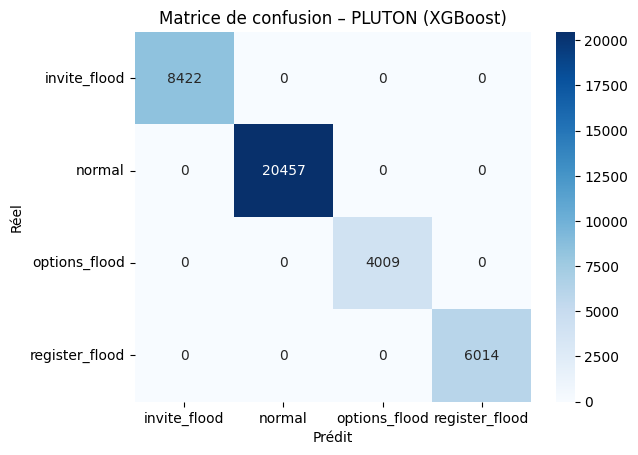

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Matrice de confusion – PLUTON (XGBoost)")
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.show()


In [11]:
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import optuna

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "objective": "multi:softprob",
        "num_class": len(label_encoder.classes_),
        "n_jobs": 4,
        "tree_method": "hist",
        "eval_metric": "mlogloss"
    }

    # split interne sur tout X_train
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2,
        random_state=trial.number, stratify=y_train
    )

    model = XGBClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average="macro")


In [12]:
import optuna, os

# — stockage SQLite pour pouvoir reprendre la recherche en cas d'interruption —
if not os.path.exists("pluton_optuna.db"):
    study = optuna.create_study(
        study_name="pluton_finetuning_full",
        direction="maximize",
        pruner=optuna.pruners.MedianPruner(),
        storage="sqlite:///pluton_optuna.db"
    )
else:
    study = optuna.load_study(
        study_name="pluton_finetuning_full",
        storage="sqlite:///pluton_optuna.db"
    )

# — lance 50 essais complets (prévois plusieurs heures) —
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("🏆 Best F1 :", study.best_value)
print("🔧 Best params :", study.best_params)


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-22 16:05:21,444] Trial 51 finished with value: 1.0 and parameters: {'n_estimators': 1200, 'max_depth': 5, 'learning_rate': 0.01005125083996466, 'subsample': 0.6575709909637882, 'colsample_bytree': 0.6789338085224697, 'gamma': 1.7567383585597516, 'min_child_weight': 1}. Best is trial 2 with value: 1.0.
[I 2025-07-22 16:05:27,530] Trial 52 finished with value: 0.999955464945926 and parameters: {'n_estimators': 400, 'max_depth': 11, 'learning_rate': 0.10213556109295667, 'subsample': 0.6009494513997555, 'colsample_bytree': 0.6467413286490588, 'gamma': 0.3351658658411291, 'min_child_weight': 1}. Best is trial 2 with value: 1.0.
[I 2025-07-22 16:05:33,804] Trial 53 finished with value: 1.0 and parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1365845534309289, 'subsample': 0.6281712189380256, 'colsample_bytree': 0.9901764233803453, 'gamma': 1.00950640490871, 'min_child_weight': 2}. Best is trial 2 with value: 1.0.
[I 2025-07-22 16:05:37,513] Trial 54 finished wi

In [13]:
from xgboost import XGBClassifier

# Ajouter les paramètres fixes
best_params.update({
    "objective": "multi:softprob",
    "num_class": len(label_encoder.classes_),
    "n_jobs": 4,
    "tree_method": "hist",
    "eval_metric": "mlogloss"
})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9690830318479461
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


                precision    recall  f1-score   support

  invite_flood       1.00      1.00      1.00      8422
        normal       1.00      1.00      1.00     20457
 options_flood       1.00      1.00      1.00      4009
register_flood       1.00      1.00      1.00      6014

      accuracy                           1.00     38902
     macro avg       1.00      1.00      1.00     38902
  weighted avg       1.00      1.00      1.00     38902



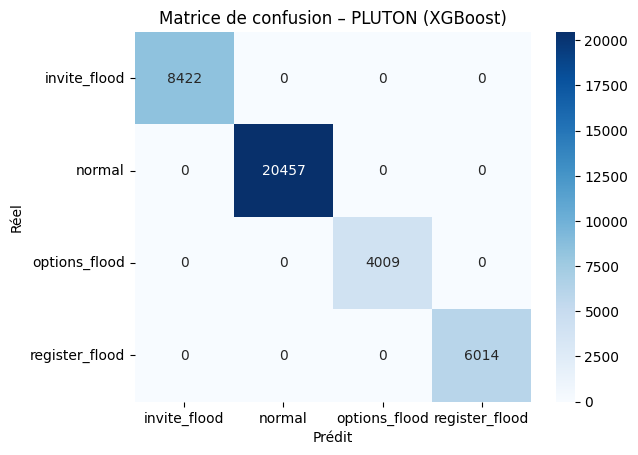

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Matrice de confusion – PLUTON (XGBoost)")
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.show()


In [16]:
import joblib, json
joblib.dump(final_model, "pluton_model.pkl")
joblib.dump(label_encoder, "pluton_label_encoder.pkl")
with open("pluton_best_params.json","w") as f:
    json.dump(best_params, f, indent=2)
print("✅ PLUTON entraîné et sauvegardé.")


✅ PLUTON entraîné et sauvegardé.


In [17]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    final_model.predict(X_test),
    target_names=label_encoder.classes_
))


                precision    recall  f1-score   support

  invite_flood       1.00      1.00      1.00      8422
        normal       1.00      1.00      1.00     20457
 options_flood       1.00      1.00      1.00      4009
register_flood       1.00      1.00      1.00      6014

      accuracy                           1.00     38902
     macro avg       1.00      1.00      1.00     38902
  weighted avg       1.00      1.00      1.00     38902



In [18]:
import joblib, json

# 1. Modèle entraîné
joblib.dump(final_model, "pluton_model.pkl")

# 2. Encodeur de labels
joblib.dump(label_encoder, "pluton_label_encoder.pkl")

# 3. Hyperparamètres optimaux
with open("pluton_best_params.json","w") as f:
    json.dump(best_params, f, indent=2)

print("✅ Fichiers sauvergardés :")
print("- pluton_model.pkl")
print("- pluton_label_encoder.pkl")
print("- pluton_best_params.json")


✅ Fichiers sauvergardés :
- pluton_model.pkl
- pluton_label_encoder.pkl
- pluton_best_params.json


In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(final_model, X_train, y_train,
                         cv=5, scoring="f1_macro", n_jobs=4)
print("5-fold F1_macro :", scores, "→ mean =", scores.mean())


5-fold F1_macro : [1. 1. 1. 1. 1.] → mean = 1.0


In [20]:
import time
start = time.time()
final_model.predict(X_test[:1000])
duration = time.time() - start
print(f"1000 sessions en {duration:.3f}s → {duration/1000*1000:.2f} ms/session")


1000 sessions en 0.011s → 0.01 ms/session
